In [21]:
import time
from src.method_selector import MlMethodSelector, ClassicMethodSelector
from src.measurement_provider import MeasurementProvider
from src.serializer import SenMLCBORSerializer, SenMLJSONSerializer
from src.signal_generator import SignalGenerator
from sys import getsizeof
from src.metric import FeatureMetricEnum, SimilarityMetricEnum
from src.data_type import Measurement
import pandas as pd
import matplotlib as plt
from src.metric import SimilarityMetricEnum
import random
plt.rcParams["figure.dpi"] = 150
pd.set_option('display.max_columns', None)

In [22]:
def compute_sizes(dataset, compressed_data, metrics):
  senML_cbor_size_original = getsizeof(SenMLCBORSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_cbor_size_compressed = getsizeof(SenMLCBORSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_cbor_size_diff = senML_cbor_size_original - senML_cbor_size_compressed
  senML_cbor_size_ratio = senML_cbor_size_diff / senML_cbor_size_original

  senML_json_size_original = getsizeof(SenMLJSONSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_json_size_compressed = getsizeof(SenMLJSONSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_json_size_diff = senML_json_size_original - senML_json_size_compressed
  senML_json_size_ratio = senML_json_size_diff / senML_json_size_original
  return {
    'senML_cbor_size_original': senML_cbor_size_original,
    'senML_cbor_size_compressed': senML_cbor_size_compressed,
    'senML_cbor_size_diff': senML_cbor_size_diff,
    'senML_cbor_size_ratio': senML_cbor_size_ratio,

    'senML_json_size_original': senML_json_size_original,
    'senML_json_size_compressed': senML_json_size_compressed,
    'senML_json_size_diff': senML_json_size_diff,
    'senML_json_size_ratio': senML_json_size_ratio,
  }

def current_milis():
  return time.time() * 1000
  
def run_measurements(dataset, get_measurements):
  constraint = {
    SimilarityMetricEnum.compression_rate: 0.5,
    SimilarityMetricEnum.sum_differences: 0.6,
    SimilarityMetricEnum.arithmetic_average: 0.5,
    SimilarityMetricEnum.standard_derivative: 0.5,
    SimilarityMetricEnum.function_field: 0.4,
    SimilarityMetricEnum.diff_of_min: 0.1,
    SimilarityMetricEnum.diff_of_max: 0.1,
    SimilarityMetricEnum.min_max_diff: 0.1,
    SimilarityMetricEnum.value_crossing: 0.4,
    SimilarityMetricEnum.positive_value_crossing: 0.4,
    SimilarityMetricEnum.negative_value_crossing: 0.4,
    SimilarityMetricEnum.peak_count: 0.4,
    SimilarityMetricEnum.positive_peak_count: 0.4,
    SimilarityMetricEnum.negative_peak_count: 0.4,
    SimilarityMetricEnum.median: 0.2,
    SimilarityMetricEnum.covariance: 0.1,
    SimilarityMetricEnum.corelation_pearson: 0.1,
    SimilarityMetricEnum.corelation_spearman: 0.1,
  }
  ml_method_selector = MlMethodSelector()
  ml_method_selector.use_constraint_strategy(constraint)
  ml_method_selector.set_measurements(dataset)
  score = ml_method_selector.train()
  print(score)

  naive_method_selector = ClassicMethodSelector()

  print("datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio")

  results = {
    "datasize": [],
    "ml_time": [],
    "naive_time": [],
    "ml_compressed_size": [],
    "naive_compressed_size": [],
    "ml_compression_ratio": [],
    "naive_compression_ratio": [],
    "ml_method": [],
    "naive_method": [],
    "ml_score": [],
    "naive_score": [],
    "ml_cbor_original_size": [],
    "ml_cbor_compressed_size": [],
    "ml_cbor_compressratio": [],
    "naive_cbor_original_size": [],
    "naive_cbor_compressed_size": [],
    "naive_cbor_compressratio": [],
    "ml_json_original_size": [],
    "ml_json_compressed_size": [],
    "ml_json_compressratio": [],
    "naive_json_original_size": [],
    "naive_json_compressed_size": [],
    "naive_json_compressratio": [],
  }

  for datasize in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    measurements = get_measurements(datasize)

    time_start = current_milis()
    compressed_data, stats, metrics = ml_method_selector.compress_with_best(measurements)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)
    metrics_score = ClassicMethodSelector().compute_similarity_with_constraint_strategy(measurements, compressed_data, constraint)

    ml_time = time_end - time_start
    ml_compressed_size = stats['compressed_size']
    ml_compression_ratio = stats['compression_rate'] * 100
    ml_method = stats['method_name']
    ml_score = metrics_score
    ml_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    ml_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    ml_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    ml_json_original_size = serialized_data_stats['senML_json_size_original']
    ml_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    ml_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['datasize'].append(datasize);
    results['ml_time'].append(ml_time);
    results['ml_compressed_size'].append(ml_compressed_size);
    results['ml_compression_ratio'].append(ml_compression_ratio);
    results['ml_method'].append(ml_method);
    results['ml_score'].append(ml_score);
    results['ml_cbor_original_size'].append(ml_cbor_original_size);
    results['ml_cbor_compressed_size'].append(ml_cbor_compressed_size);
    results['ml_cbor_compressratio'].append(ml_cbor_compressratio);
    results['ml_json_original_size'].append(ml_json_original_size);
    results['ml_json_compressed_size'].append(ml_json_compressed_size);
    results['ml_json_compressratio'].append(ml_json_compressratio);

    ##############################################

    time_start = current_milis()
    compressed_data, stats, metrics, metrics_score = naive_method_selector.compress_with_best_constraint_strategy(measurements, constraint)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)

    naive_time = time_end - time_start
    naive_compressed_size = stats['compressed_size']
    naive_compression_ratio = stats['compression_rate'] * 100
    naive_method = stats['method_name']
    naive_score = metrics_score
    naive_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    naive_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    naive_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    naive_json_original_size = serialized_data_stats['senML_json_size_original']
    naive_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    naive_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['naive_time'].append(naive_time);
    results['naive_compressed_size'].append(naive_compressed_size);
    results['naive_compression_ratio'].append(naive_compression_ratio);
    results['naive_method'].append(naive_method);
    results['naive_score'].append(naive_score);
    results['naive_cbor_original_size'].append(naive_cbor_original_size);
    results['naive_cbor_compressed_size'].append(naive_cbor_compressed_size);
    results['naive_cbor_compressratio'].append(naive_cbor_compressratio);
    results['naive_json_original_size'].append(naive_json_original_size);
    results['naive_json_compressed_size'].append(naive_json_compressed_size);
    results['naive_json_compressratio'].append(naive_json_compressratio);

    print(f'{datasize},{ml_time},{naive_time},{ml_compressed_size},{naive_compressed_size},{ml_compression_ratio},{naive_compression_ratio},{ml_method},{naive_method},{ml_score},{naive_score},{ml_cbor_original_size},{ml_cbor_compressed_size},{ml_cbor_compressratio},{naive_cbor_original_size},{naive_cbor_compressed_size},{naive_cbor_compressratio},{ml_json_original_size},{ml_json_compressed_size},{ml_json_compressratio},{naive_json_original_size},{naive_json_compressed_size},{naive_json_compressratio}')
  return pd.DataFrame.from_dict(results)

In [23]:
dataset = MeasurementProvider().get_random3()
# df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).linear(2.5).sin(1, 0.2)))
df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).with_peaks(4).with_peaks(3, direction=-1).sin(2, 0.2).linear(0.05).noise()))

(0.4, 0.9333333333333333)
datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
100,2.348876953125,138.103271484375,40,20,60.0,80.0,CompressPIP_ED_0.4,CompressPIP_ED_0.2,86.9485,80.967,2323,1125,0.5157124408092983,2323,725,0.6879035729659922,5370,2355,0.5614525139664804,5367,1344,0.7495807713806596
200,5.218017578125,335.190185546875,80,20,60.0,90.0,CompressPIP_ED_0.4,CompressPIP_PD_0.1,89.0769,80.993,4323,1924,0.554938699976868,4323,725,0.832292389544298,10456,4383,0.5808148431522571,10516,1396,0.8672499049068086
300,10.298095703125,687.660888671875,120,60,60.0,80.0,CompressPIP_ED_0.4,CompressPIP_P

In [24]:
# df = pd.read_csv('./results3a.csv')
# df['ml_compression_ratio'] *= 100
# df['naive_compression_ratio'] *= 100

In [25]:
# df1 = df
# df = df1
df

,datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
0,100,2.348877,138.103271,40,20,60.0,80.0,CompressPIP_ED_0.4,CompressPIP_ED_0.2,86.9485,80.9670,2323,1125,0.515712,2323,725,0.687904,5370,2355,0.561453,5367,1344,0.749581
1,200,5.218018,335.190186,80,20,60.0,90.0,CompressPIP_ED_0.4,CompressPIP_PD_0.1,89.0769,80.9930,4323,1924,0.554939,4323,725,0.832292,10456,4383,0.580815,10516,1396,0.867250
2,300,10.298096,687.660889,120,60,60.0,80.0,CompressPIP_ED_0.4,CompressPIP_PD_0.2,90.7578,85.9924,6324,2723,0.569418,6324,1525,0.758855,15630,6447,0.587524,15630,3386,0.783365
3,400,14.472412,1019.090820,160,80,60.0,80.0,CompressPIP_ED_0.4,CompressPIP_ED_0.2,87.8668,86.2994,8324,3525,0.576526,8324,1925,0.768741,20849,8558,0.589525,20847,4455,0.786300
4,500,19.779297,1389.494873,200,50,60.0,90.0,CompressPIP_ED_0.4,CompressPIP_ED_0.1,89.4984,84.4781,10324,4324,0.581170,10324,1324,0.871755,25928,10545,0.593297,25974,2914,0.887811
5,600,28.351074,1969.201904,240,60,60.0,90.0,CompressPIP_ED_0.4,CompressPIP_PD_0.1,89.5164,83.3139,12324,5125,0.584145,12324,1525,0.876258,31149,12674,0.593117,31119,3386,0.891192
6,700,39.025635,2583.319092,280,70,60.0,90.0,CompressPIP_ED_0.4,CompressPIP_PD_0.1,85.0483,83.0644,14412,5960,0.586456,14412,1733,0.879753,36295,14751,0.593580,36250,3915,0.892000
7,800,44.278076,3130.184082,320,80,60.0,90.0,CompressPIP_ED_0.4,CompressPIP_PD_0.1,81.5562,84.0288,16612,6836,0.588490,16612,1955,0.882314,41468,16809,0.594651,41449,4485,0.891795
8,900,56.844727,3926.720703,360,180,60.0,80.0,CompressPIP_ED_0.4,CompressPIP_PD_0.2,80.2651,78.3940,18812,7713,0.589996,18812,4023,0.786147,46541,18833,0.595346,46572,9617,0.793503
9,1000,60.453125,4888.259277,400,100,60.0,90.0,CompressPIP_ED_0.4,CompressPIP_PD_0.1,88.3550,83.3563,21012,8576,0.591852,21012,2395,0.886018,51633,20873,0.595743,51661,5496,0.893614


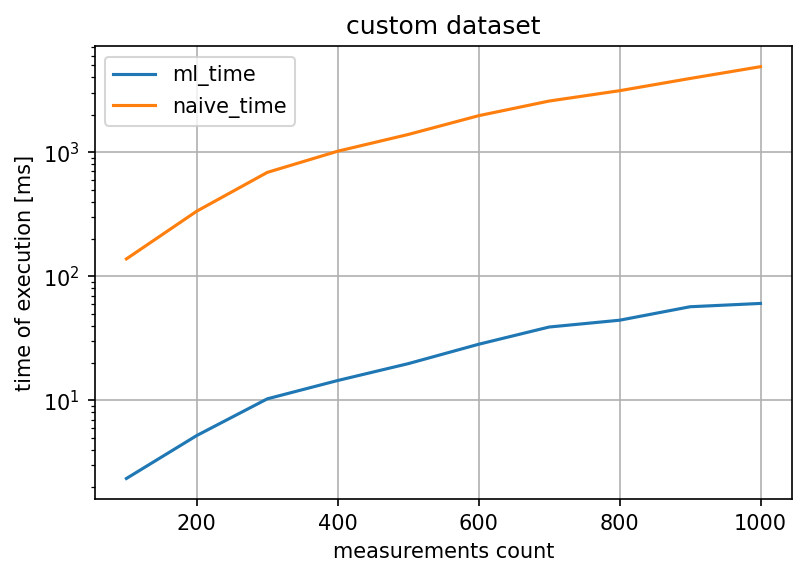

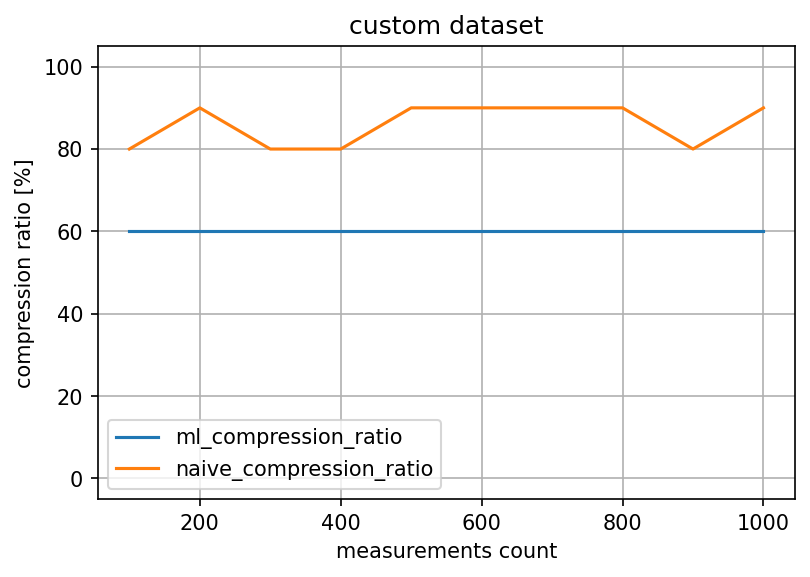

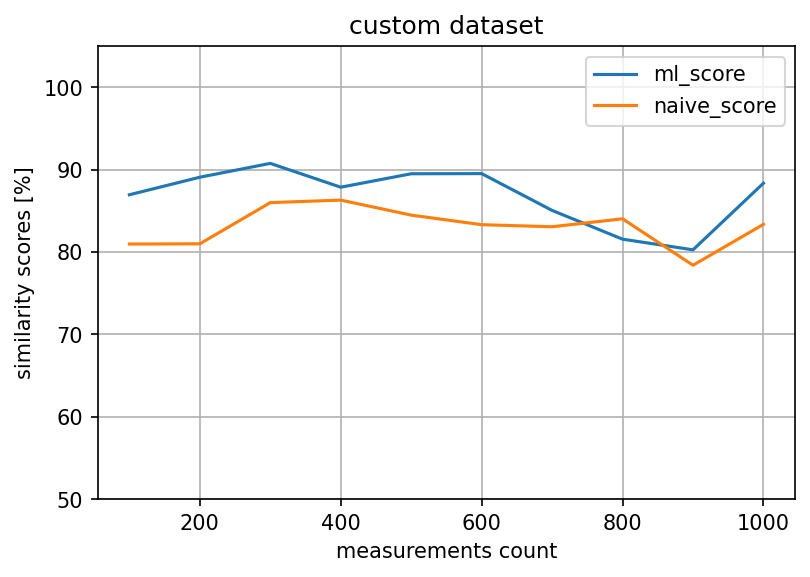

In [26]:
path = '../plot/strategy3'
ax = df.plot(x='datasize', y=['ml_time', 'naive_time'], grid=True)
ax.set_yscale("log")
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1a.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'naive_compression_ratio'], grid=True)
ax.set_ylim(-5, 105)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2a.png')

# ax = df.plot(x='datasize', y=['ml_compressed_size', 'naive_compressed_size'], grid=True)
# ax.set_title("custom dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("compresed measurement set count")
# ax.figure.savefig(f'{path}/3a.png')

ax = df.plot(x='datasize', y=['ml_score', 'naive_score'], grid=True)
ax.set_ylim(50, 105)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4a.png')

# ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'naive_cbor_compressed_size', 'ml_json_compressed_size', 'naive_json_compressed_size'], grid=True, ylim=0)
# ax.set_title("custom dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("data size [B]")
# ax.figure.savefig(f'{path}/5a.png')


In [27]:
measurements1 = MeasurementProvider().json_to_measurements('stock1.json')
size1 = len(measurements1)
dataset = []
for i in range(10):
  start = int(random.randint(0, size1) * 0.7)
  end = random.randint(start, size1)
  dataset.append(measurements1[start:end])
df = run_measurements(dataset, lambda datasize: MeasurementProvider().json_to_measurements('stock1.json')[:datasize])

(0.5, 0.5)
datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
100,1.611083984375,129.787109375,10,20,90.0,80.0,CompressPIP_ED_0.1,CompressPIP_ED_0.2,100,84.9824,2529,549,0.7829181494661922,2529,769,0.6959272439699487,5745,915,0.8407310704960835,5723,1430,0.7501310501485235
200,2.726318359375,330.76513671875,20,20,90.0,90.0,CompressPIP_PD_0.1,CompressPIP_PD_0.1,92.2792,92.2792,4729,769,0.8373863396066822,4729,769,0.8373863396066822,11119,1405,0.8736397158017807,11119,1405,0.8736397158017807
300,4.628173828125,584.533935546875,60,30,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,89.3989,82.9687,69

In [28]:
# df = pd.read_csv('./results3b.csv')
# df['ml_compression_ratio'] *= 100
# df['naive_compression_ratio'] *= 100

In [29]:
df2 = df
# df = df2
df

,datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
0,100,1.611084,129.787109,10,20,90.0,80.0,CompressPIP_ED_0.1,CompressPIP_ED_0.2,100.0000,84.9824,2529,549,0.782918,2529,769,0.695927,5745,915,0.840731,5723,1430,0.750131
1,200,2.726318,330.765137,20,20,90.0,90.0,CompressPIP_PD_0.1,CompressPIP_PD_0.1,92.2792,92.2792,4729,769,0.837386,4729,769,0.837386,11119,1405,0.873640,11119,1405,0.873640
2,300,4.628174,584.533936,60,30,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,89.3989,82.9687,6930,1649,0.762049,6930,989,0.857287,16530,3555,0.784936,16529,1933,0.883054
3,400,6.551025,932.953125,80,80,80.0,80.0,CompressPIP_PD_0.2,CompressPIP_PD_0.2,88.8557,88.8557,9130,2089,0.771194,9130,2089,0.771194,21967,4651,0.788273,21967,4651,0.788273
4,500,10.602051,1327.411865,50,100,90.0,80.0,CompressPIP_ED_0.1,CompressPIP_PD_0.2,100.0000,90.5013,11330,1429,0.873875,11330,2529,0.776787,27368,3001,0.890346,27366,5707,0.791457
5,600,13.709961,1755.202637,60,60,90.0,90.0,CompressPIP_ED_0.1,CompressPIP_PD_0.1,80.8854,87.7717,13530,1649,0.878123,13530,1649,0.878123,32900,3611,0.890243,32900,3615,0.890122
6,700,17.122070,2294.006104,70,70,90.0,90.0,CompressPIP_ED_0.1,CompressPIP_PD_0.1,82.6342,85.2459,15730,1869,0.881182,15730,1869,0.881182,38343,4170,0.891245,38311,4145,0.891807
7,800,18.632080,2810.178955,80,80,90.0,90.0,CompressPIP_ED_0.1,CompressPIP_ED_0.1,78.7615,78.7615,17930,2089,0.883491,17930,2089,0.883491,43707,4672,0.893106,43707,4672,0.893106
8,900,21.247803,3479.780029,90,90,90.0,90.0,CompressPIP_ED_0.1,CompressPIP_ED_0.1,86.7178,86.7178,20130,2309,0.885296,20130,2309,0.885296,49270,5258,0.893282,49270,5258,0.893282
9,1000,8.134766,4190.739746,100,100,90.0,90.0,CompressPAA_0.1,CompressPIP_PD_0.1,100.0000,93.2408,22330,2929,0.868831,22330,2529,0.886744,54836,6044,0.889780,54744,5745,0.895057


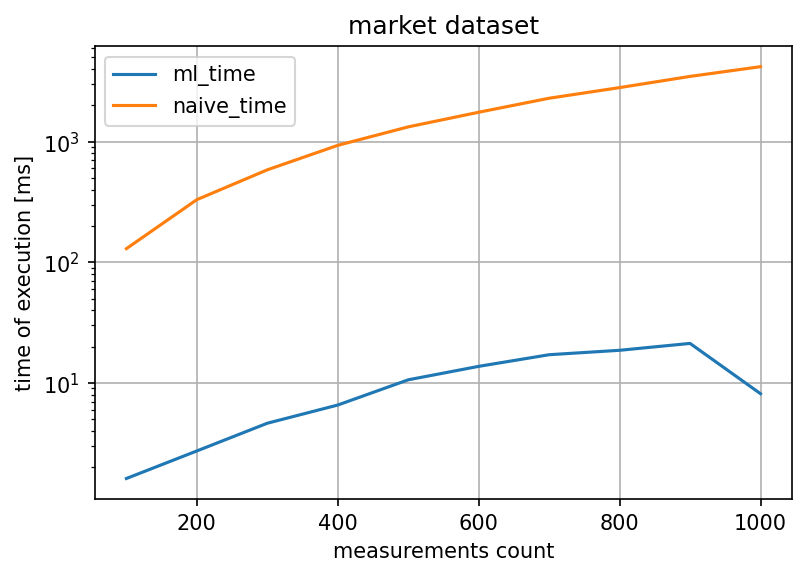

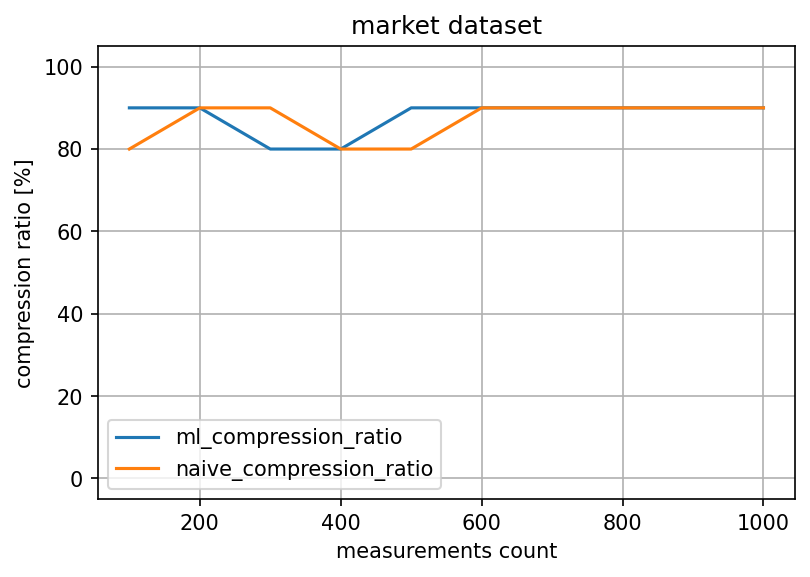

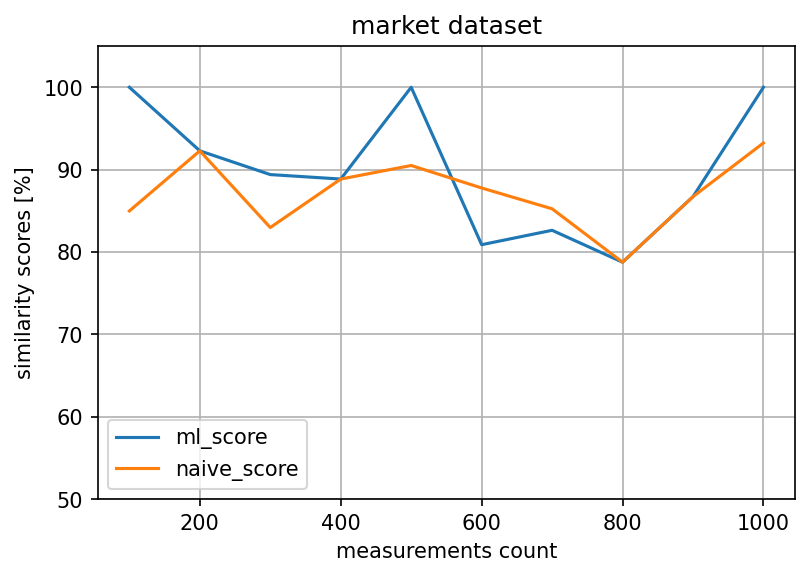

In [30]:
path = '../plot/strategy3'
ax = df.plot(x='datasize', y=['ml_time', 'naive_time'], grid=True)
ax.set_yscale("log")
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1b.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'naive_compression_ratio'], grid=True)
ax.set_ylim(-5, 105)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2b.png')

# ax = df.plot(x='datasize', y=['ml_compressed_size', 'naive_compressed_size'], grid=True)
# ax.set_title("market dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("compresed measurement set count")
# ax.figure.savefig(f'{path}/3b.png')

ax = df.plot(x='datasize', y=['ml_score', 'naive_score'], grid=True)
ax.set_ylim(50, 105)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4b.png')

# ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'naive_cbor_compressed_size', 'ml_json_compressed_size', 'naive_json_compressed_size'], grid=True, ylim=0)
# ax.set_title("market dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("data size [B]")
# ax.figure.savefig(f'{path}/5b.png')

